In [302]:
# installations

# !pip install numpy
# !pip install scipy
# !pip install math
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib

In [246]:
import importlib.util as import_util
import_util.find_spec('venv')

ModuleSpec(name='venv', loader=<_frozen_importlib_external.SourceFileLoader object at 0x1173c87d0>, origin='/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/venv/__init__.py', submodule_search_locations=['/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/venv'])

In [247]:
# imports

import numpy as np
import scipy
import math
from collections.abc import Sequence

In [688]:
# secondary imports
import pandas as pd
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

In [339]:
type prior = tuple[str, tuple]
type design = tuple[str, tuple]

# allowed priors: normal, rademacher, 3-point, laplace, bernoulli*normal
# params need to be: (tau2, None), None, (p, q), (theta, None), (p, tau2)
def vamp_bayes_se(design : Sequence[design], prior_info : Sequence[prior], error_var, iter = 100, retrieve = False) :

    # keep the SE params in arrays
    b_bar = []
    eta2_2 = []
    gamma_2bar = []
    c_bar = []
    eta2_1 = []
    gamma_1bar = []

    # initializations
    sigma2 = error_var
    rri_type, svd = design              
    s, _ = svd # limiting empirical dist of singular values

    eta2_1_k = 0
    gamma_1bar_k = 1
    
    # -----------------------------------------------------------------------------------------
    
    for k in range(iter) :
        # append the initializations or updates to their respective storage arrays
        gamma_1bar.append(gamma_1bar_k)
        eta2_1.append(eta2_1_k)

        # -----------------------------------------------------------------------------------------

        # updates part 1

        # update (b_bar)_k via function to compute the expectation of f'
        b_bar_k = compute_kappa(prior_info, gamma_1bar_k, eta2_1_k)

        # update (eta^2)_2 k via function to compute expectation of f^2
        xi2_1_k = compute_xi2_1(prior_info, gamma_1bar_k, eta2_1_k)
        C2_1 = (1 / (1 - b_bar_k)) ** 2
        eta2_2_k = C2_1 * (xi2_1_k - b_bar_k ** 2 * eta2_1_k)

        # update (gamma_bar)_2 k
        gamma_2bar_k = gamma_1bar_k * (1/b_bar_k - 1)

        # update c_bar_k
        c_bar_k = (sigma2 * gamma_2bar_k) / ((s ** 2) + sigma2 * gamma_2bar_k)

        # -----------------------------------------------------------------------------------------

        # interlude before updating the next round
        # append the new state evolution params to the vectors
        b_bar.append(b_bar_k)
        eta2_2.append(eta2_2_k)
        gamma_2bar.append(gamma_2bar_k)
        c_bar.append(c_bar_k)
        
        # -----------------------------------------------------------------------------------------

        # updates part 2
        # now continue updating next round

        # update (eta^2)_1 k+1
        xi2_2_k = ((s) / (s ** 2 + sigma2 * gamma_2bar_k)) ** 2 * sigma2 + ((sigma2 * gamma_2bar_k) / (s ** 2 + sigma2 * gamma_2bar_k)) ** 2 * eta2_2_k
        C2_2 = (1 / (1 - c_bar_k)) ** 2
        eta2_1_k = C2_2 * (xi2_2_k - c_bar_k ** 2 * eta2_2_k)

        # update (gamma_bar)_1 k+1
        gamma_1bar_k = gamma_2bar_k * (1/c_bar_k - 1)
    
    if retrieve :
        return gamma_1bar, gamma_2bar, eta2_1, eta2_2, b_bar, c_bar
    
    else :
        return gamma_1bar[-1], eta2_1[-1]
    

# with numerical integration
def tweedie_mean(y, prior_name, prior_params, gamma_1):
    
    if prior_name == "gaussian":
        tau2, _ = prior_params
        
        return (tau2 * gamma_1 / (1 + tau2 * gamma_1)) * y

    elif prior_name == "rademacher":
        return np.tanh(gamma_1 * y)

    elif prior_name == "laplace":
        theta, _ = prior_params
        beta_grid = np.linspace(-10 * theta, 10 * theta, 10000)
        prior_pdf = np.exp(-np.abs(beta_grid) / theta) / (2 * theta)
        likelihood = np.exp(-0.5 * gamma_1 * (y - beta_grid)**2)
        integrand = beta_grid * prior_pdf * likelihood
        normalizer = np.trapz(prior_pdf * likelihood, beta_grid)
        return np.trapz(integrand, beta_grid) / normalizer

    elif prior_name == "three_point":
        p, q = prior_params
        r = 1 - p - q
        points = np.array([-1, 0, 1])
        weights = np.array([p, q, r])
        likelihood = np.exp(-0.5 * gamma_1 * (y - points)**2)
        normalizer = np.sum(weights * likelihood)
        return np.sum(points * weights * likelihood) / normalizer

    elif prior_name == "bernoulli_gaussian":
        p, tau2 = prior_params
        beta_grid = np.linspace(-5 * np.sqrt(tau2), 5 * np.sqrt(tau2), 8000)

        # Continuous (slab) component
        slab_pdf = np.exp(-0.5 * beta_grid**2 / tau2) / np.sqrt(2 * np.pi * tau2)
        likelihood_cont = np.exp(-0.5 * gamma_1 * (y - beta_grid)**2)

        cont_num = p * np.trapz(beta_grid * slab_pdf * likelihood_cont, beta_grid)
        cont_den = p * np.trapz(slab_pdf * likelihood_cont, beta_grid)

        # Discrete spike at 0
        likelihood_spike = np.exp(-0.5 * gamma_1 * y**2)
        spike_num = 0.0
        spike_den = (1 - p) * likelihood_spike

        return (cont_num + spike_num) / (cont_den + spike_den)

    else:
        raise ValueError("prior given is not yet supported")

# using tweedie
def tweedie_derivative(y, prior_name, prior_params, gamma_1, delta=1e-4):
    return (tweedie_mean(y + delta, prior_name, prior_params, gamma_1)
            - tweedie_mean(y - delta, prior_name, prior_params, gamma_1)) / (2 * delta)

# compute kappa_k
def compute_kappa(prior, gamma_1bar, eta2_1_k):
    prior_name, prior_params = prior
    
    if prior_name == "gaussian":
        tau2, _ = prior_params
        return (tau2 * gamma_1bar) / (1 + tau2 * gamma_1bar)
    
    N = 5000
    Pk = np.random.normal(0, np.sqrt(eta2_1_k), N)

    derivs = np.array([tweedie_derivative(p, prior_name, prior_params, gamma_1bar) for p in Pk])
    
    return np.mean(derivs)

# compute xi^2_{1k}
def compute_xi2_1(prior, gamma_1bar, eta2_1_k):
    prior_name, prior_params = prior
    N = 5000
    Pk = np.random.normal(0, np.sqrt(eta2_1_k), N)

    if prior_name == "gaussian":
        tau2, _ = prior_params
        kappa = (tau2 * gamma_1bar) / (1 + tau2 * gamma_1bar)
        return kappa**2 * (tau2 + eta2_1_k)

    f_vals = np.array([tweedie_mean(p, prior_name, prior_params, gamma_1bar) for p in Pk])
    
    return np.mean(f_vals**2)


In [681]:
# lasso_vamp_tag

def vamp_lasso(X, y, reg_lambda = 1, oracle_sigma2 = 1, max_iter = 100, tol = 1e-8, verbose = False) :

    # soft thresholding denoiser for lasso
    def soft_threshold(x, threshold):
        return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

    def subgradient_soft_threshold(r_1, threshold):
        grad = np.zeros_like(r_1)
        grad[np.abs(r_1) > threshold] = 1.0
        grad[np.isclose(np.abs(r_1), threshold)] = 0.75
        
        return grad

    n, p = X.shape
    # delta_inv = p / n

    # initialization
    r_1 = np.random.normal(loc = 0, scale = 1, size = p)
    gamma_1 = 1

    # iterate
    for _ in range(max_iter) :
        
        # update beta_hat
        beta_hat = soft_threshold(r_1, reg_lambda / (gamma_1+1e-12))

        # check divergence
        if np.isnan(np.linalg.norm(beta_hat)) :
            print("divergence")
            return beta_hat

        # update b
        b = np.mean(subgradient_soft_threshold(r_1, reg_lambda / (gamma_1+1e-12)))

        # update eta 1
        eta_1 = gamma_1 / (b+1e-12)
        
        # update gamma 2
        gamma_2 = eta_1 - gamma_1

        # update r_2
        r_2 = (1 /(gamma_2+1e-12)) * (eta_1*beta_hat - gamma_1*r_1)

        # update c for gamma_1
        inv_arg = np.linalg.inv((1/oracle_sigma2) * X.T @ X + gamma_2 * np.eye(p))
        c = (1/p) * np.trace(gamma_2 * inv_arg)

        # update gamma_1
        gamma_1 = gamma_2 * (1/(c+1e-12) - 1)

        # update r_1
        r_1 = (1 / (1-c)) * (inv_arg @ (1/oracle_sigma2 * X.T @ y + gamma_2*r_2) - c*r_2)

    return beta_hat

In [682]:
def vamp_ridge(X, y, reg_lambda = 1, oracle_sigma2 = 1, max_iter = 100, tol = 1e-8, verbose = False) :

    # soft thresholding denoiser for ridge
    def l2_shrinkage(x, threshold):
        return (1.0 / (1.0 + threshold)) * x

    def gradient_shrinkage(x, threshold):
        scale = 1.0 / (1.0 + threshold)
        return np.full_like(x, scale)

    n, p = X.shape
    # delta_inv = p / n

    # initialization
    r_1 = np.random.normal(loc = 0, scale = 1, size = p)
    gamma_1 = 1.0

    # iterate
    for k in range(max_iter) :
        
        # update beta_hat
        beta_hat = l2_shrinkage(r_1, reg_lambda / (gamma_1+1e-12))

        # check divergence
        if np.isnan(np.linalg.norm(beta_hat)) :
            print("divergence")
            return beta_hat

        # update b
        b = np.mean(gradient_shrinkage(r_1, reg_lambda / (gamma_1+1e-12)))

        # update eta 1
        eta_1 = gamma_1 / (b+1e-12)
        
        # update gamma 2
        gamma_2 = eta_1 - gamma_1

        # update r_2
        r_2 = (1/ (gamma_2+1e-12)) * (eta_1 * beta_hat - gamma_1 * r_1)

        # update c for gamma_1
        inv_arg = np.linalg.inv((1/oracle_sigma2) * X.T @ X + gamma_2 * np.eye(p))
        c = (1/p) * np.trace(gamma_2 * inv_arg)

        # update gamma_1
        gamma_1 = gamma_2 * (1/(c+1e-12) - 1)

        # update r_1
        r_1 = (1 / (1-c)) * (inv_arg @ (1/oracle_sigma2 * X.T @ y + gamma_2*r_2) - c*r_2)

    return beta_hat

In [663]:
# bayes VAMP

type prior = tuple[str, tuple]
# allowed priors: normal, rademacher, 3-point, laplace, bernoulli*normal
# params need to be: (tau2, None), None, (p, q), (theta, None), (p, tau2)

# compute conditional expectation using tweedie
def tweedie_f(r_1, gamma_1, marginal_density):
    # compute the log for tweedie
    logp_prime = scipy.differentiate.derivative(lambda x: np.log(marginal_density(x)), r_1).df
    
    return r_1 + (1 / gamma_1) * logp_prime

# compute f = E[beta | beta + N(0, 1/gamma_1) = r]
def f_condexp(r_1, gamma_1, prior, prior_params):
    
    # gaussian: beta_bar ~ N(0, tau^2)
    # -----------------------------------------------------------------------------------------

    if prior == "gaussian":
        tau2, _ = prior_params

        # closed form solution
        f_vals = (tau2 * gamma_1 / (1 + tau2 * gamma_1)) * r_1

    # rademacher: beta_bar ~ Uniform{-1, 1}
    # -----------------------------------------------------------------------------------------
    elif prior == "rademacher":
        # no prior params
        
        # closed form solution
        f_vals = np.tanh(gamma_1 * r_1)

    # three point: beta_bar ~ {-1 : p, 0 : q, 1 : (1 - p-q)}
    # -----------------------------------------------------------------------------------------
    elif prior == "three_point":
        theta_1, theta_2 = prior_params
        
        # compute density for the derivative
        def marginal_density(r):
            return (
                theta_1 * scipy.stats.norm.pdf(r + 1, scale = np.sqrt(1/gamma_1))
                + theta_2 * scipy.stats.norm.pdf(r, scale = np.sqrt(1/gamma_1))
                + (1 - theta_1 - theta_2) * scipy.stats.norm.pdf(r - 1, scale = np.sqrt(1/gamma_1))
            )
        
        # compute derivative for numerator
        def density_derivative(r):
            return (
                -1 * gamma_1 * (theta_1 * scipy.stats.norm.pdf(r + 1, scale = np.sqrt(1/gamma_1)) * (r_1+1)
                + theta_2 * scipy.stats.norm.pdf(r, scale = np.sqrt(1/gamma_1)) * (r_1)
                + (1 - theta_1 - theta_2) * scipy.stats.norm.pdf(r - 1, scale = np.sqrt(1/gamma_1)) * (r_1-1))
            )

        # tweedie's formula 
        f_vals = 1/gamma_1 * density_derivative(r_1) / (marginal_density(r_1) + 1e-12) + r_1

    # laplace: beta_bar ~ laplace(theta)
    # -----------------------------------------------------------------------------------------
    elif prior == "laplace":
        theta, _ = prior_params
        
        def marginal_density(r):
            integrand = lambda b: (1 / (2*theta)) * np.exp(-abs(b) / theta) * scipy.stats.norm.pdf(r-b, scale = np.sqrt(1/gamma_1))
            return scipy.integrate.quad(integrand, -np.inf, np.inf, limit = 200)[0]
        
        f_vals = tweedie_f(r_1, gamma_1, marginal_density)

    # bernoulli/normal mix: beta_bar ~ laplace(theta)
    # -----------------------------------------------------------------------------------------
    elif prior == "bernoulli_normal":
        theta, tau2 = prior_params
        
        # compute density for the derivative
        def marginal_density(r):
            return (1-theta) * scipy.stats.norm.pdf(r, 0, np.sqrt(1 / gamma_1)) + theta * scipy.stats.norm.pdf(r, 0, np.sqrt(tau2 + 1/gamma_1))
        
        # compute derivative for the numerator
        def density_derivative(r) :
            return -1 * ((1-theta) * scipy.stats.norm.pdf(r, 0, np.sqrt(1/gamma_1)) * (gamma_1 * r_1) + theta * scipy.stats.norm.pdf(r, 0, np.sqrt(tau2 + 1/gamma_1)) * (r_1 / (tau2 + 1/gamma_1)))
        
        # use tweedie's formula
        f_vals = 1/gamma_1 * density_derivative(r_1) / (marginal_density(r_1) + 1e-12) + r_1

    else:
        raise ValueError("given prior is not yet supported")

    return f_vals

# for f = E[beta | beta + N(0, 1/gamma_1) = r], compute f'(r) wrt r
def f_derivative(r_1, gamma_1, prior, prior_params):

    # gaussian: beta_bar ~ N(0, tau^2)
    # -----------------------------------------------------------------------------------------
    if prior == "gaussian" :
        tau2, _ = prior_params
        
        # full_like to facilitate return of a vector of values, although constant
        return np.full_like(r_1, (gamma_1 * tau2) / (gamma_1 * tau2 + 1))
    
    # rademacher: beta_bar ~ Uniform{-1, 1}
    # -----------------------------------------------------------------------------------------
    if prior == "rademacher":
        if gamma_1 > 500.0 :
            return np.zeros(len(r_1))
          
        return gamma_1 * (1/np.cosh(gamma_1 * r_1)) ** 2

    # otherwise, derivative is not as nice: for three-point, bernoulli/normal, laplace
    # -----------------------------------------------------------------------------------------
    def f_single(x):
        return f_condexp(x, gamma_1, prior, prior_params)

    # use scipy derivative package
    return scipy.differentiate.derivative(f_single, r_1).df
    
    
# bv_tag
def vamp_bayes(X, y, prior_info : Sequence[prior], oracle_sigma2, max_iter = 100, tol = 1e-8, retrieve = False, verbose = False) :

    n, p = X.shape
    # delta_inv = p / n

    prior_name, prior_params = prior_info

    # initialization
    r_1_k = 0.01 * np.ones(p)
    gamma_1_k = 0.05

    # empty arrays to store iterates
    beta_hat = []
    r_1 = []
    r_2 = []

    # iterate
    for k in range(max_iter) :

        # add r_1 to storage
        r_1.append(r_1_k)

        # -----------------------------------------------------------------------------------------

        # updates part 1 --- f and f'
        
        # update beta_hat
        beta_hat_k = f_condexp(r_1_k, gamma_1_k, prior_name, prior_params)

        # print(r_1_k)

        # update b
        b_k = np.mean(f_derivative(r_1_k, gamma_1_k, prior_name, prior_params))
        
        # -----------------------------------------------------------------------------------------

        # parts where prior doesn't matter
         # update eta 1
        eta_1_k = gamma_1_k / (b_k + 1e-12)
        
        # update gamma 2
        gamma_2_k = eta_1_k - gamma_1_k

        # update r_2
        r_2_k = (1 / (gamma_2_k + 1e-12)) * (eta_1_k * beta_hat_k - gamma_1_k * r_1_k)

        # -----------------------------------------------------------------------------------------
        
        # append new updates for storage
        beta_hat.append(beta_hat_k)
        r_2.append(r_2_k)

        # -----------------------------------------------------------------------------------------

        if k > 1 and (1/p * np.linalg.norm(beta_hat[-1] - beta_hat[-2])) < tol :
            if verbose :
                print("converged at iteration " + str(k))
            if retrieve :
                return beta_hat, r_1, r_2
            else :
                return beta_hat[-1]
            
        # -----------------------------------------------------------------------------------------

        # updates part 2, continue
        
        # update c for gamma_1
        inv_arg = np.linalg.inv((1/oracle_sigma2) * X.T @ X + gamma_2_k * np.eye(p))
        c_k = (1/p) * np.trace(gamma_2_k * inv_arg)

        # update gamma_1
        gamma_1_k = gamma_2_k * (1/(c_k + 1e-12) - 1)

        # update r_1
        r_1_k = (1 / (1 - c_k + 1e-12)) * (inv_arg @ (1/oracle_sigma2 * X.T @ y + gamma_2_k * r_2_k) - c_k * r_2_k)

    if retrieve :
        return beta_hat, r_1, r_2
        
    return beta_hat[-1]

In [11]:
# this cell is the AMP iteration helpers

def init_beta(p, mean = 0, var = 1, method = "gaussian", scaling = 1) :
    if method == "gaussian" :
        beta_hat = np.random.normal(loc = 0, scale = math.sqrt(var), size = p)

    elif method == "zeros" :
        beta_hat = np.zeros(p)

    elif method == "ones" :
        beta_hat = scaling * np.ones(p)      
        
    else :
        print("not done yet 2")
        
    return beta_hat

In [253]:
# this cell is the Bayes AMP algorithm function

# X is design matrix, y is outcome, eta2 is initialization variance for beta_hat
# oracle_params are the known parameters for noise varianace and prior variance for beta_0 true
def amp_bayes(X, y, eta2 = 1, oracle_params = (1, 1), max_iter = 100, tol = 1e-8, verbose = False):

    def f_denoiser(x, sigma2_k, tau2) :
        return x * tau2 / (tau2 + sigma2_k)

    n, p = X.shape
    delta_inv = p / n

    oracle_sigma2, oracle_tau2 = oracle_params

    # initialization
    beta_hat = init_beta(p, "gaussian", var = eta2)
    r_hat = np.zeros(n)
    r_prev = np.zeros(n)
    b = 1

    # base case
    sigma2 = oracle_sigma2 + delta_inv * (oracle_tau2 + eta2)

    # iterate
    for _ in range(max_iter):

        # check divergence
        if np.isnan(np.linalg.norm(beta_hat)) :
            print("divergence")
            return beta_hat

        # update r_hat
        r_new = y - X @ beta_hat + b * r_hat

        # update sigma_k
        sigma2_new = oracle_sigma2 + delta_inv * (oracle_tau2 - (oracle_tau2 ** 2 / (oracle_tau2 + sigma2)))

        # update beta_hat
        denoiser_input = X.T @ r_new + beta_hat
        beta_new = f_denoiser(denoiser_input, sigma2_new, oracle_tau2)

        # update b
        b = p * oracle_tau2 / (n * (oracle_tau2 + sigma2_new))

        # store old iterate
        r_prev = r_hat
        r_hat = r_new

        sigma2_prev = sigma2
        sigma2 = sigma2_new

        # check convergence
        diff = np.linalg.norm(beta_hat - beta_new)
        if diff < tol * (np.linalg.norm(beta_hat) + 1e-12):
            beta_hat = beta_new

            if verbose :
                print("converged")
            break

        beta_hat = beta_new

    return beta_hat

In [254]:
# this cell is the AMP LASSO algorithm function

def amp_lasso(X, y, reg_lambda, max_iter = 500, tol = 1e-6):

    # soft thresholding denoiser for lasso
    def soft_threshold(x, threshold):
        return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)
    
    n, p = X.shape

    # initialization
    beta_hat = init_beta(p, "gaussian")
    r_hat = np.zeros(n)
    r_prev = np.zeros(n)

    # iterate
    for _ in range(max_iter):

        # check divergence
        if np.isnan(np.linalg.norm(beta_hat)) :
            print("divergence")
            return beta_hat

        # get the zero norm of beta_hat
        beta_norm_0 = np.count_nonzero(beta_hat)

        # update r_hat
        r_new = y - X @ beta_hat + (beta_norm_0 / n) * r_prev

        # get values for beta_hat update
        t_next = reg_lambda / (1 - (beta_norm_0 / n))

        # update beta_hat
        beta_new = soft_threshold(X.T @ r_new + beta_hat, t_next)

        # store old iterate
        r_prev = r_hat
        r_hat = r_new

        # check convergence
        diff = np.linalg.norm(beta_hat - beta_new)
        if diff < tol * (np.linalg.norm(beta_hat) + 1e-12):
            beta_hat = beta_new
            break

        beta_hat = beta_new

    return beta_hat

In [317]:
# this cell is the data generation helpers

def generate_beta(p, mean = 0.0, var = 1.0, prior = "gaussian") :
    if prior == "gaussian" :
        beta = np.random.normal(loc = 0, scale = math.sqrt(var), size = p)

    elif prior == "sparse_gaussian" :
        print("not done yet 5")
        
    elif prior == "other" :
        print("not done yet 3")
    return beta

def generate_gaussian_design(n, p, symmetry = "asymmetric") :
    if symmetry == "symmetric" :
        if n != p :
            print("symmetric matrices need to have same row and column dimensions")
        else :
            print("not done yet 1")

    elif symmetry == "asymmetric" :
        matrix = np.random.normal(loc = 0, scale = 1 / math.sqrt(n), size = (n, p))
        
    else :
        print("invalid matrix type")
        
    return matrix

def generate_response(design_matrix, signal, noise_var) :
    n, p = design_matrix.shape
    error = np.random.normal(loc = 0, scale = math.sqrt(noise_var), size = n)

    return design_matrix @ signal + error

def generate_rri_design(n, p, k = -1, method = "lln") :
    if method == "lln" :
        if k == -1 :
            k = p
            
        X_1 = np.random.normal(loc = 0, scale = 1, size = (n, k))
        X_2 = np.random.normal(loc = 0, scale = 1, size = (k, k))
        X_3 = np.random.normal(loc = 0, scale = 1, size = (k, k))
        X_4 = np.random.normal(loc = 0, scale = 1, size = (k, p))
        
        X = (1 / math.sqrt(n)) * X_1 @ X_2 @ X_3 @ X_4

    if method == "heavy_tail" :
        df = 3
        mean = np.zeros(p)
        scale = np.eye(p)
        X = scipy.stats.multivariate_t.rvs(loc = mean, shape = scale, df = df, size = n)

    if method == "spiked" :
        X, V, W, signal, noise = generate_spiked(n, p)
    
    else :
        print("invalid matrix type")

    return X

# helper for generating spiked matrix
def haar_orthonormal_columns(n, m):
    G = np.random.normal(size = (n, m))
    Q, R = np.linalg.qr(G)
    
    signs = np.sign(np.diag(R))
    signs[signs == 0] = 1.0
    Q = Q * signs[np.newaxis, :]
    return Q

# helper for spiked matrix generation
def generate_spiked(n, p, m = 50, alpha = 10.0, seed = None):
    if m > min(n, p):
        raise ValueError("m must be <= min(n, p)")
    
    V = haar_orthonormal_columns(n, m) 
    W = haar_orthonormal_columns(p, m) 

    signal = alpha * (V @ W.T)               
    noise = (1.0/math.sqrt(n)) * np.random.normal(size = (n, p))

    X = signal + noise

    return X, V, W, signal, noise

In [55]:
## FIRST, AMP LASSO. 
# THREE THINGS TO CHECK
    # matches LASSO solution
    # ASYMPTOTIC NORMALITY
    # check the phase transition for different values of delta

delta = 3.0

p = 100
n = int(delta * p)

sigma2 = 0.01

beta_bernnorm = np.random.binomial(1, 0.5, size = p) * generate_beta(p)
X_lamp = generate_gaussian_design(n, p)
y_lamp = generate_response(X_lamp, beta_bernnorm, sigma2)

lambda_lamp = 0.15
estimate_lamp = amp_lasso(X_lamp, y_lamp, lambda_lamp, max_iter = 25)

lasso_lambda = 1/n * lambda_lamp
lasso_model = Lasso(alpha = lasso_lambda)
lasso_model.fit(X_lamp, y_lamp)
estimate_lasso = lasso_model.coef_

compare_estimates_lamp = pd.DataFrame(np.array([beta_bernnorm, estimate_lamp, estimate_lasso]).T, columns = ['true_beta', 'lasso_amp_estimate', 'lasso_estimate'])
compare_estimates_lamp.round(4)

0.22499999999999998 1.6271185955757748
0.19823788546255508 0.7256631244395474
0.1939655172413793 0.8945207270600526
0.20089285714285715 1.1044261959732369
0.19736842105263158 1.2036714273045106
0.20361990950226244 1.5662523354008169
0.2054794520547945 1.9603338517046969
0.21327014218009477 2.65099360650197
0.2142857142857143 3.8043194380673886
0.2173913043478261 5.033624022024773
0.2173913043478261 8.894433225985217
0.21951219512195122 10.535045793564452
0.22277227722772278 21.845046281593486
0.2216748768472906 24.615845868820468
0.22388059701492538 54.5901234804649
0.22388059701492538 60.420037137760865
0.22499999999999998 138.6700310430844
0.22499999999999998 150.62184835722775
0.22499999999999998 355.92487693708887
0.22499999999999998 377.9317300822807
0.22499999999999998 920.2483606429995
0.22499999999999998 957.5871357033634
0.22499999999999998 2394.8488961945095
0.22499999999999998 2457.376627843553
0.22499999999999998 6270.2593622245


,true_beta,lasso_amp_estimate,lasso_estimate
0,0.4695,-4496.2130,0.1058
1,-0.3472,-1791.9359,-0.2756
2,-0.5617,2034.4444,-0.4148
3,-0.0000,1754.6501,0.0000
4,0.6878,-1184.7921,0.5410
...,...,...,...
95,0.0000,243.3770,0.0000
96,-0.5482,-147.9841,-0.3797
97,-0.0000,-6008.4427,0.0000
98,0.0000,1995.7208,0.0000


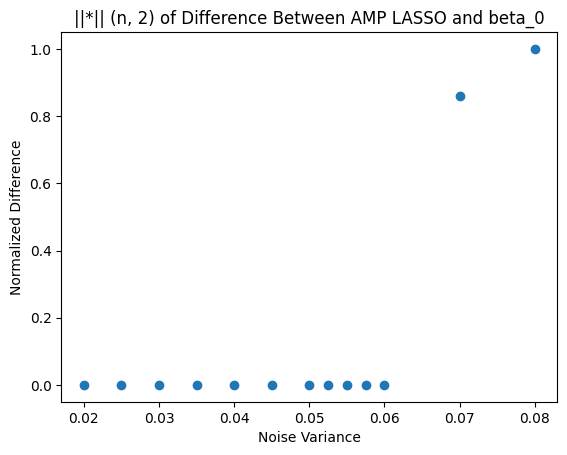

In [1123]:
# phase transition AMP LASSO vs true beta_0

delta = 5.0

p = 200
n = int(delta * p)

sigmas2 = [0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.0525, 0.055, 0.0575, 0.06, 0.07, 0.08]
error_diffs = []

for sigma2 in sigmas2 :

    errors = []

    for _ in range(50) :
        beta_bernnorm = np.random.binomial(1, 0.4, size = p) * generate_beta(p)
        X_lamp = generate_gaussian_design(n, p)
        y_lamp = generate_response(X_lamp, beta_bernnorm, sigma2)
        
        lambda_lamp = .15
        estimate_lamp = amp_lasso(X_lamp, y_lamp, lambda_lamp)
        
        lambda_lasso = 0.000145
        lasso = Lasso(alpha = lasso_lambda)
        lasso.fit(X_lamp, y_lamp)
        estimate_lasso = lasso.coef_
    
        errors.append(1/p * np.linalg.norm(beta_bernnorm - estimate_lamp))

    error_diffs.append(np.median(np.array(errors)))

error_diffs = 1/np.max(np.array(error_diffs)) * np.array(error_diffs)

plt.scatter(sigmas2, error_diffs)
plt.title("||*|| (n, 2) of Difference Between AMP LASSO and beta_0", size = 12)
plt.xlabel("Noise Variance")
plt.ylabel("Normalized Difference")
plt.show()

In [1168]:
## SECOND, AMP BAYES. 
# TWO THINGS TO CHECK
    # ASYMPTOTIC NORMALITY
    # check the phase transition for different values of delta

delta = 5.0

p = 200
n = int(delta * p)

sigma2 = 0.001
tau2 = 1

beta_norm = generate_beta(p)
X_bamp = generate_gaussian_design(n, p)
y_bamp = generate_response(X_bamp, beta_norm, sigma2)

estimate_bamp = amp_bayes(X_bamp, y_bamp, oracle_params = (sigma2, tau2), max_iter = 100)

compare_estimates_bamp = pd.DataFrame(np.array([beta_norm, estimate_bamp]).T, columns = ['true_beta', 'bayes_amp_estimate'])
compare_estimates_bamp.round(4)

,true_beta,bayes_amp_estimate
0,-0.2287,-0.2523
1,0.4742,0.4461
2,0.6411,0.6673
3,-0.0309,-0.0466
4,2.4970,2.4670
...,...,...
195,1.1224,1.1170
196,-1.5459,-1.5173
197,0.7047,0.6695
198,0.5429,0.5348


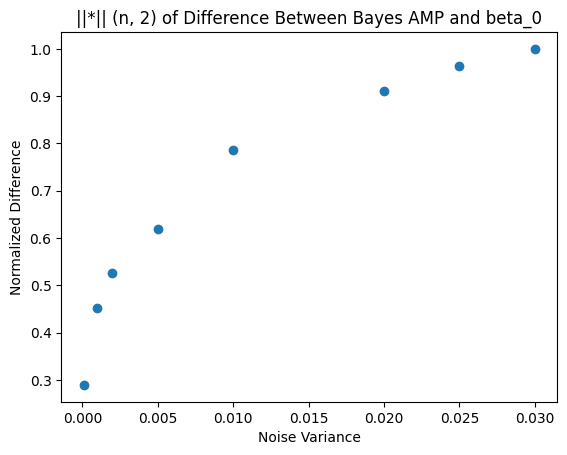

In [1150]:
# check phase transition

delta = 1.0

p = 200
n = int(delta * p)

sigmas2 = [0.0001, 0.001, 0.002, 0.005, 0.01, 0.02, 0.025, 0.03]
tau2 = 1

error_diffs = []

for sigma2 in sigmas2 :
    errors = []

    for _ in range(50) :
        beta_norm = generate_beta(p)
        X_bamp = generate_gaussian_design(n, p)
        y_bamp = generate_response(X_bamp, beta_norm, sigma2)
        
        estimate_bamp = amp_bayes(X_bamp, y_bamp, oracle_params = (sigma2, tau2), max_iter = 100)
        errors.append(1/p * np.linalg.norm(beta_norm - estimate_bamp))

    error_diffs.append(np.median(errors))

error_diffs = 1/np.max(np.array(error_diffs)) * np.array(error_diffs)

plt.scatter(sigmas2, error_diffs)
plt.title("||*|| (n, 2) of Difference Between Bayes AMP and beta_0", size = 12)
plt.xlabel("Noise Variance")
plt.ylabel("Normalized Difference")
plt.show()

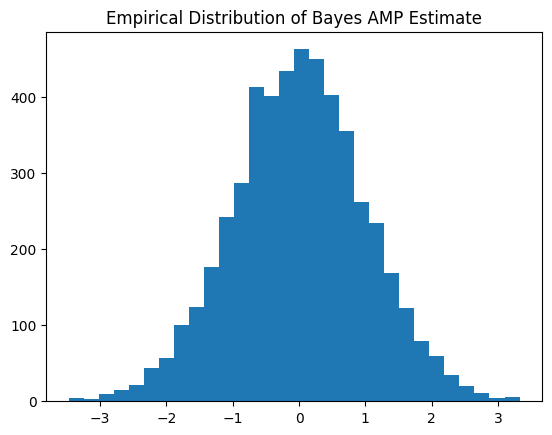

In [1192]:
# check asymptotic normality for bayes AMP

delta = 1.5

p = 5000
n = int(delta * p)

sigma2 = 0.001
tau2 = 1

beta_norm = generate_beta(p)
X_bamp = generate_gaussian_design(n, p)
y_bamp = generate_response(X_bamp, beta_norm, sigma2)

estimate_bamp = amp_bayes(X_bamp, y_bamp, oracle_params = (sigma2, tau2), max_iter = 100)

plt.hist(estimate_bamp, bins = 30)
plt.title("Empirical Distribution of Bayes AMP Estimate")
plt.show()

In [1264]:
# NOW, LASSO VAMP
# FOUR THINGS TO CHECK
    # matches LASSO solution
    # ASYMPTOTIC NORMALITY
    # check the phase transition for different values of delta
    # better than AMP for various RRI matrices

delta = 5.0

p = 200
n = int(delta * p)

sigma2 = 0.01

beta_bernnorm = np.random.binomial(1, 0.4, size = p) * generate_beta(p)
X_lvamp = generate_rri_design(n, p, method = "heavy_tail")
y_lvamp = generate_response(X_lvamp, beta_bernnorm, sigma2)

lambda_lamp = 0.15
lambda_lvamp = 1.0
estimate_lvamp = vamp_lasso(X_lvamp, y_lvamp, reg_lambda = lambda_lvamp)
estimate_lamp = amp_lasso(X_lvamp, y_lvamp, reg_lambda = lambda_lamp, max_iter = 1)

lambda_lasso = 0.00145
lasso = Lasso(alpha = lasso_lambda)
lasso.fit(X_lvamp, y_lvamp)
estimate_lasso = lasso.coef_

compare_estimates_lvamp = pd.DataFrame(np.array([beta_bernnorm, estimate_lvamp, estimate_lamp, estimate_lasso]).T, columns = ['true_beta', 'lasso_vamp_estimate', 'lasso_amp_estimate', 'lasso_estimate'])
compare_estimates_lvamp.round(4)

,true_beta,lasso_vamp_estimate,lasso_amp_estimate,lasso_estimate
0,0.0000,0.0000,3129.2521,0.0002
1,-0.0000,0.0002,3571.2943,0.0009
2,0.4159,0.4135,5563.5787,0.4138
3,0.0000,-0.0011,-827.1718,-0.0017
4,-0.0000,0.0000,-2028.7258,0.0009
...,...,...,...,...
195,0.0000,-0.0006,-3673.5110,-0.0006
196,0.0000,0.0052,-4637.5128,0.0059
197,-0.1723,-0.1706,-5843.5950,-0.1708
198,-0.0000,0.0011,-145.0795,0.0027


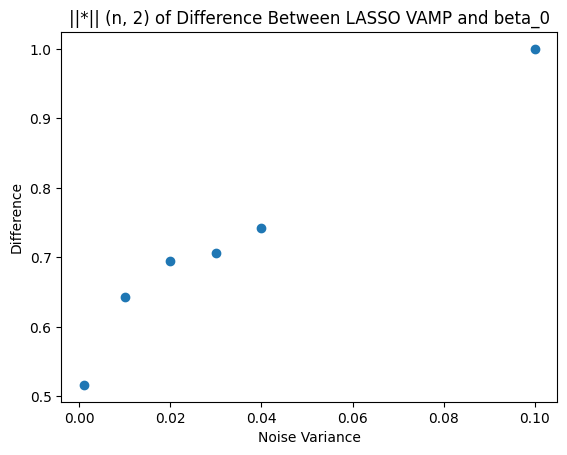

In [1322]:
# check phase transition of lasso VAMP

delta = .8

p = 200
n = int(delta * p)

sigmas2 = [0.001, 0.01, 0.02, 0.03, 0.04, 0.1]

error_diffs = []

for sigma2 in sigmas2 :
    errors = []

    for _ in range(50) :
        beta_bernnorm = np.random.binomial(1, 0.4, size = p) * generate_beta(p)
        X_lvamp = generate_rri_design(n, p, method = "heavy_tail")
        y_lvamp = generate_response(X_lvamp, beta_bernnorm, sigma2)
        
        lambda_lvamp = 1.0
        estimate_lvamp = vamp_lasso(X_lvamp, y_lvamp, reg_lambda = lambda_lvamp)

        errors.append(1/p * np.linalg.norm(estimate_lvamp - beta_bernnorm))
        
    error_diffs.append(np.median(errors))

error_diffs = 1/np.max(np.array(error_diffs)) * np.array(error_diffs)

plt.scatter(sigmas2, error_diffs)
plt.title("||*|| (n, 2) of Difference Between LASSO VAMP and beta_0", size = 12)
plt.xlabel("Noise Variance")
plt.ylabel("Difference")
plt.show()
plt.show()

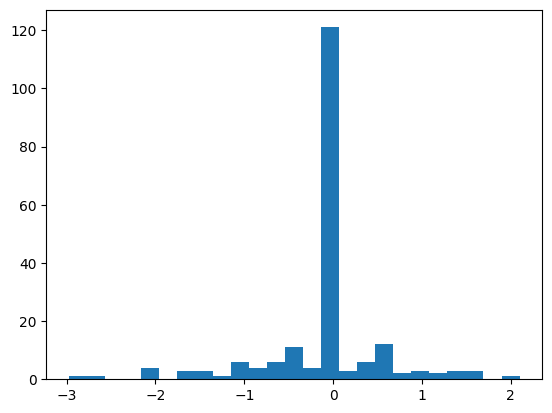

In [1268]:
# check asymptotic dist of lasso VAMP---not normal

delta = 5.0

p = 200
n = int(delta * p)

sigma2 = 0.01

beta_bernnorm = np.random.binomial(1, 0.4, size = p) * generate_beta(p)
X_lvamp = generate_rri_design(n, p, method = "heavy_tail")
y_lvamp = generate_response(X_lvamp, beta_bernnorm, sigma2)
estimate_lvamp = vamp_lasso(X_lvamp, y_lvamp, reg_lambda = lambda_lvamp)

plt.hist(estimate_lvamp, bins = 25)
plt.show()

In [1272]:
# NOW, Bayes VAMP
# THREE THINGS TO CHECK
    # ASYMPTOTIC NORMALITY
    # check the phase transition for different values of delta
    # better than AMP for various RRI matrices

delta = 5.0

p = 200
n = int(delta * p)

sigma2 = 0.01
tau2 = 1

beta_norm = generate_beta(p)
X_bvamp = generate_rri_design(n, p, method = "heavy_tail")
y_bvamp = generate_response(X_bvamp, beta_norm, sigma2)

estimate_bvamp = vamp_bayes(X_bvamp, y_bvamp, oracle_params = (sigma2, tau2))
estimate_bamp = amp_bayes(X_bvamp, y_bvamp, oracle_params = (sigma2, tau2), max_iter = 2)

compare_estimates_bvamp = pd.DataFrame(np.array([beta_norm, estimate_bvamp, estimate_bamp]).T, columns = ['true_beta', 'bayes_vamp_estimate', 'bayes_amp_estimate'])
compare_estimates_bvamp.round(4)

,true_beta,bayes_vamp_estimate,bayes_amp_estimate
0,-1.2416,-1.2431,-1.390031e+08
1,-1.4592,-1.4612,1.480109e+08
2,0.6001,0.6024,-1.505635e+08
3,-0.4543,-0.4572,2.164297e+08
4,1.4693,1.4703,-1.055389e+07
...,...,...,...
195,-2.1607,-2.1642,5.254715e+07
196,0.8336,0.8303,-2.702534e+08
197,0.9799,0.9836,-3.807008e+07
198,0.0805,0.0783,-6.488767e+07


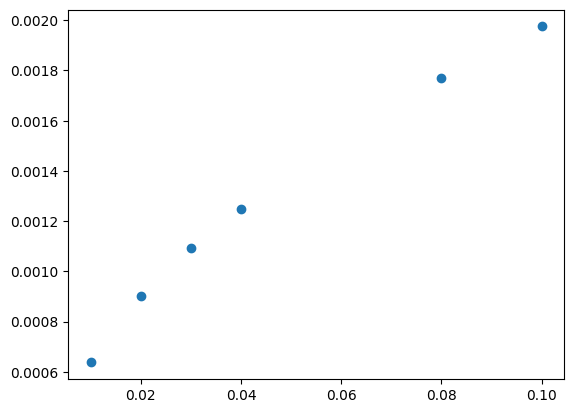

In [1288]:
# check for phase transition

delta = 1.5

p = 200
n = int(delta * p)

sigmas2 = [0.01, 0.02, 0.03, 0.04, 0.08, 0.1]
tau2 = 1

error_diff = []

for sigma2 in sigmas2 :
    errors = []

    for _ in range(50) :

        beta_norm = generate_beta(p)
        X_bvamp = generate_rri_design(n, p, method = "heavy_tail")
        y_bvamp = generate_response(X_bvamp, beta_norm, sigma2)
        
        estimate_bvamp = vamp_bayes(X_bvamp, y_bvamp, oracle_params = (sigma2, tau2))

        errors.append(1/p * np.linalg.norm(estimate_bvamp - beta_norm))
        
    error_diff.append(np.median(errors))

plt.scatter(sigmas2, error_diff)
plt.show()

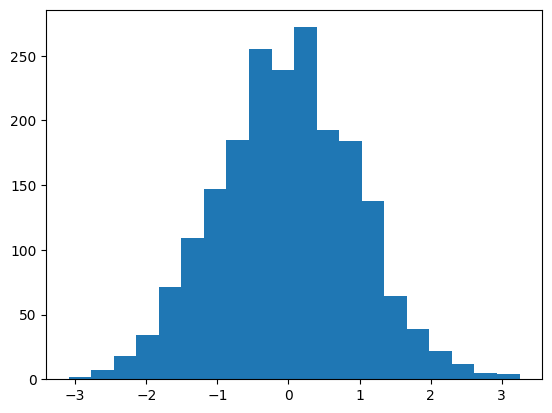

In [1332]:
# check asymptotic normality for bayes VAMP on RRI matrices

delta = 2.0

p = 2000
n = int(delta * p)

sigma2 = 0.01
tau2 = 1

beta_norm = generate_beta(p)
X_bvamp = generate_rri_design(n, p, method = "lln")
y_bvamp = generate_response(X_bvamp, beta_norm, sigma2)

estimate_bvamp = vamp_bayes(X_bvamp, y_bvamp, oracle_params = (sigma2, tau2))

plt.hist(estimate_bvamp, bins = 20)
plt.show()

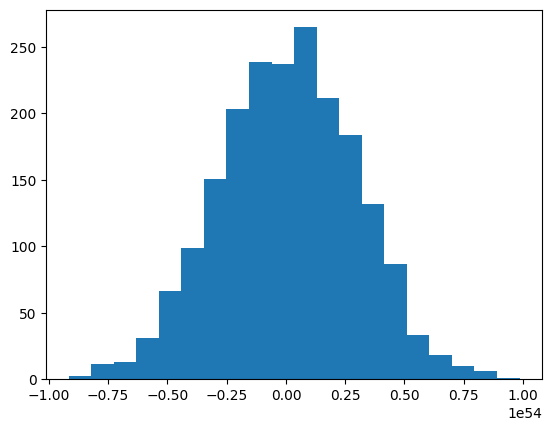

In [1333]:
# check asymptotic "normality" for bayes AMP on RRI matrices

estimate_bamp = amp_bayes(X_bvamp, y_bvamp, oracle_params = (sigma2, tau2), max_iter = 5)

plt.hist(estimate_bamp, bins = 20)
plt.show()

new_plot


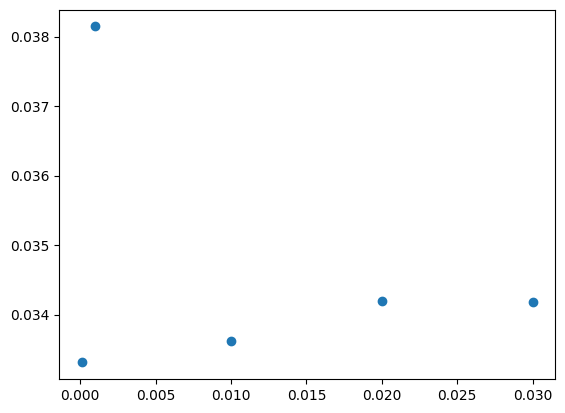

In [362]:
# amp_bayes(X, y, eta2 = 1, oracle_params = (1, 1), max_iter = 100000, tol = 1e-6)

delta = 0.6

p = 1000
n = int(delta * p)

mse = []

sigmas2 = [0.0001, 0.001, 0.01, 0.02, 0.03]

for sigma2 in sigmas2 :
    new_mse = []

    for _ in range(100) :

        tau2 = 1
        
        beta_true = generate_beta(p, var = tau2)
        X = generate_gaussian_design(n, p)
        y = generate_response(X, beta_true, noise_var = sigma2)
        
        b_amp = amp_bayes(X, y, eta2 = 1, oracle_params = (sigma2, tau2), max_iter = 100)
        new_mse.append(np.linalg.norm(b_amp - beta_true))

    avg_mse = np.mean(np.array(new_mse))
    mse.append(1 / n * avg_mse)

print('new_plot')
plt.scatter(sigmas2, y = mse)
plt.show()

In [ ]:
# amp_bayes(X, y, eta2 = 1, oracle_params = (*sigma2*, *tau2*), max_iter = 100000, tol = 1e-6)

n = 50000
p = 100000

mse = []

sigmas2 = [0.0001, 0.0002, 0.0003, 0.0004, 0.001, 0.01, 0.02]

for sigma2 in sigmas2 :
    new_mse = []

    for _ in range(1) :

        tau2 = 1
        
        beta_true = generate_beta(p, var = tau2)
        X = generate_gaussian_design(n, p)
        y = generate_response(X, beta_true, noise_var = sigma2)
        
        b_amp = amp_bayes(X, y, eta2 = 1, oracle_params = (sigma2, tau2), max_iter = 100000)
        new_mse.append(np.linalg.norm(b_amp - beta_true))

    avg_mse = np.median(np.array(new_mse))
    mse.append(1 / n * avg_mse)
    
plt.scatter(sigmas2, y = mse)
plt.xlim(-0.01, 0.025)
plt.ylim(0, 0.05)
plt.show()

In [657]:
# this cell is to check the divergence---why is it happening?

# amp_bayes(X, y, eta2 = 1, oracle_params = (*sigma2*, *tau2*), max_iter = 100000, tol = 1e-6)

n = 3000
p = 600

tau2 = 1
sigma2 = 0.1

for _ in range(10) :
    beta_true = generate_beta(p, var = tau2)
    X = generate_gaussian_design(n, p)
    y = generate_response(X, beta_true, noise_var = sigma2)
    b_amp = amp_bayes(X, y, eta2 = 1, oracle_params = (sigma2, tau2), max_iter = 100)

In [659]:
#b_amp = amp_bayes(X, y, eta2 = 1, oracle_params = (sigma2, tau2), max_iter = 10)
outputs = pd.DataFrame(np.array([beta_true, b_amp]).T, columns = ['true_beta', 'bayes_amp_estimate'])
outputs.round(4)

,true_beta,bayes_amp_estimate
0,-0.7020,-0.6899
1,0.9310,0.9735
2,0.6527,1.0100
3,0.9928,0.5999
4,-0.9905,-0.8761
...,...,...
595,0.9234,0.7117
596,0.1130,0.2104
597,0.2735,0.1119
598,-0.3959,-0.0799


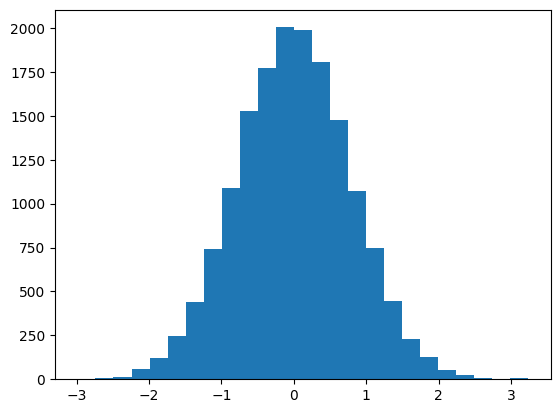

In [202]:
# this cell is to plot the distribution of the iterates for Bayes AMP

n = 10000
p = 16000

tau2 = 1
sigma2 = 0.01

beta_true = generate_beta(p, var = tau2)
X = generate_gaussian_design(n, p)
y = generate_response(X, beta_true, noise_var = sigma2)
beta = amp_bayes(X, y, eta2 = 1, oracle_params = (sigma2, tau2), max_iter = 100)

plt.hist(beta, bins = 25)
plt.show()

In [73]:
# this cell is to plot the distribution of the iterates for LASSO AMP

# LASSO AMP 
# WITH BERNOULLI/NORMAL MIX

betas = []

n = 1000
p = 5000

reg_lambda = 0.5
beta_true = generate_beta(p, mean = 0) # * np.random.binomial(1, 0.2, size = p)
X = generate_gaussian_design(n, p)
y = generate_response(X, beta_true, 0.01)

# plt.hist([val for val in beta if val != 0], bins = 20)
# plt.hist(beta, bins = 20)
# plt.show()

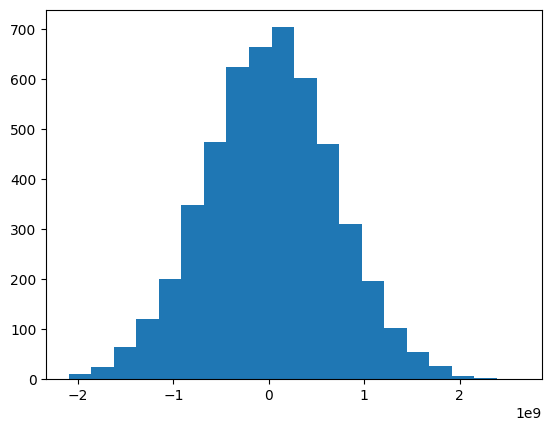

In [75]:
beta = amp_lasso(X, y, reg_lambda, max_iter = 10)

plt.hist([val for val in beta if val != 0], bins = 20)
#plt.hist(beta, bins = 20)
plt.show()

In [972]:
# this cell is to plot the distribution of the iterates for Bayes AMP

n = 1000
p = 900

tau2 = 1
sigma2 = 0.0001

beta_true = generate_beta(p, var = tau2)
X = generate_rri_design(n, p, method = "heavy_tail")
y = generate_response(X, beta_true, noise_var = sigma2)
beta_vamp = vamp_bayes(X, y, oracle_params = (sigma2, tau2), max_iter = 100, verbose = True)
beta_amp = amp_bayes(X, y, eta2 = 1, oracle_params = (sigma2, tau2), max_iter = 2)

outputs = pd.DataFrame(np.array([beta_true, beta_vamp, beta_amp]).T, columns = ['true_beta', 'bayes_vamp_estimate', "bayes_amp_estimate"])
outputs.round(4)

# plt.hist(beta_vamp, bins = 20)
# plt.show()

,true_beta,bayes_vamp_estimate,bayes_amp_estimate
0,0.2938,0.2938,4.727382e+08
1,-0.3444,-0.3449,1.608574e+08
2,-0.4303,-0.4283,1.088142e+09
3,-1.3702,-1.3728,-5.525810e+08
4,0.2490,0.2497,5.038305e+08
...,...,...,...
895,1.3631,1.3646,4.017266e+08
896,-0.4348,-0.4358,7.171118e+08
897,0.6239,0.6260,-3.934768e+08
898,-0.5085,-0.5085,1.105605e+09


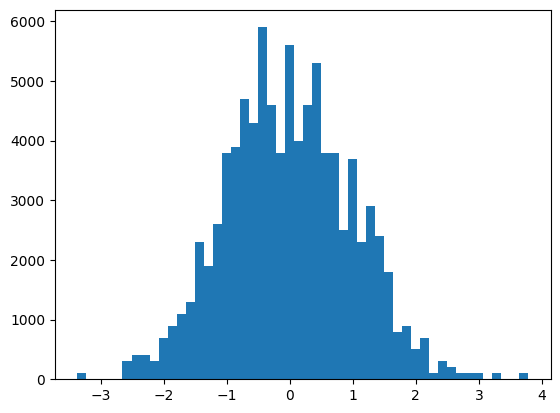

In [980]:
#plt.hist(beta_amp, bins = 25, alpha = 0.5)
estimates = []

for _ in range(100) :
    estimates.append(vamp_bayes(X, y, oracle_params = (sigma2, tau2), max_iter = 100, verbose = True))

plt.hist(np.array(estimates).flatten(), bins = 50, alpha = 1.0)
plt.show()

In [684]:
# this cell is to test the LASSO VAMP with bernoulli/gaussian mix prior

# LASSO AMP 
# WITH BERNOULLI/NORMAL MIX

n = 1000
p = 500

beta_true = np.random.binomial(1, 0.6, size = p) * generate_beta(p)
X = generate_rri_design(n, p, method = "heavy_tail")
y = generate_response(X, beta_true, 0.01)

reg_lambda = .5
lasso = Lasso(alpha=0.0018)
lasso.fit(X, y)

outputs = pd.DataFrame(np.array([beta_true, vamp_lasso(X, y, reg_lambda, max_iter = 100), amp_lasso(X, y, reg_lambda, max_iter = 2), lasso.coef_]).T, columns = ['true_beta', 'vamp_estimate', 'amp_estimate', 'lasso_estimate'])

outputs.round(4)

,true_beta,vamp_estimate,amp_estimate,lasso_estimate
0,-0.0000,-0.0052,-2.350328e+07,-0.0031
1,0.5510,0.5492,-1.146882e+08,0.5480
2,-1.5481,-1.5489,2.047131e+08,-1.5488
3,-0.9583,-0.9555,3.233704e+08,-0.9547
4,1.9115,1.9132,7.963300e+06,1.9120
...,...,...,...,...
495,-0.0000,-0.0000,2.161027e+08,-0.0018
496,-0.4652,-0.4672,3.750386e+08,-0.4649
497,-0.4147,-0.4170,-3.229912e+08,-0.4154
498,0.0000,0.0059,-8.000703e+07,0.0007


In [916]:
outputs = pd.DataFrame(np.array([beta_true, amp_lasso(X, y, reg_lambda, max_iter = 2), lasso.coef_]).T, columns = ['true_beta', 'vamp_estimate', 'lasso_estimate'])

outputs.round(4)

,true_beta,vamp_estimate,lasso_estimate
0,0.0000,-1.569499e+08,0.0007
1,-0.9324,8.875565e+07,-0.9312
2,-0.9575,6.624649e+07,-0.9568
3,0.0000,-5.922449e+07,-0.0011
4,0.2439,1.858423e+08,0.2413
...,...,...,...
195,-0.0000,3.977193e+07,-0.0013
196,1.5489,2.282842e+08,1.5437
197,1.3214,-1.691631e+08,1.3232
198,0.0000,5.382538e+07,0.0005


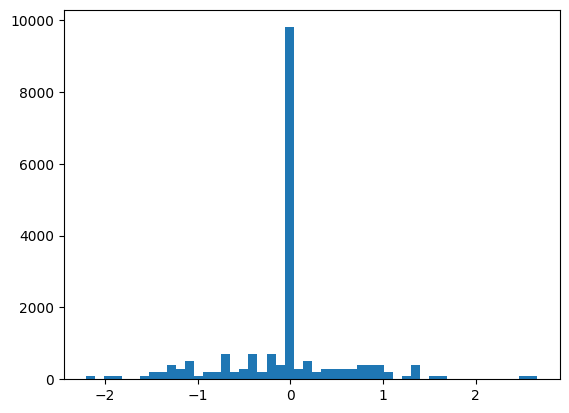

In [936]:
estimates = []

for _ in range(100) :
    estimates.append(vamp_bayes(X, y, max_iter = 20))

plt.hist(np.array(estimates).flatten(), bins = 50)
plt.show()

In [68]:
# vamp_bayes_se(design : svd, prior : Sequence[prior], error_var, iter = 100, retrieve = False)
n = 200
p = 200

X = generate_rri_design(n, p, method = "heavy_tail")
beta_0 = generate_beta(p, var = 1)

In [242]:
U, Sigma, V = np.linalg.svd(X)

s = np.mean(Sigma[:p])

In [341]:
design = ("heavy_tail", (s, None))
prior = ('gaussian', (1, None))

# allowed priors: normal, rademacher, 3-point, laplace, bernoulli*normal
# params need to be: (tau2, None), None, (p, q), (theta, None), (p, tau2)
gamma_1bar, gamma_2bar, eta2_1, eta2_2, b_bar, c_bar = vamp_bayes_se(design, prior, error_var = 0.1, iter = 5, retrieve = True)

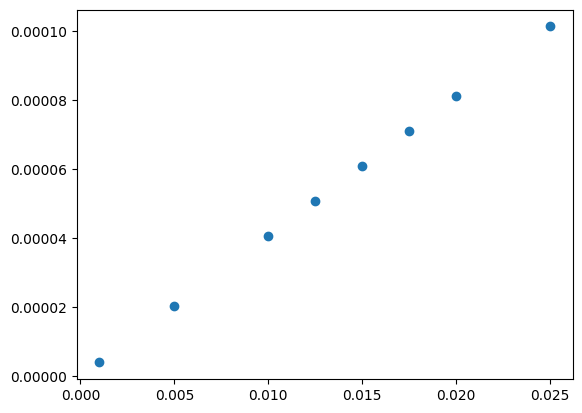

In [342]:
sigmas2 = [0.001, 0.005, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.025]

params = []

for sigma2 in sigmas2 :
    params.append(vamp_bayes_se(design, prior, error_var = sigma2, iter = 10, retrieve = False))

mse_vals = []

for k in range(len(sigmas2)) :
    mse_vals.append(1 / ((1 + params[k][0]) ** 2) + params[k][1] * (params[k][0]) ** 2 / (1 + params[k][0]) ** 2)

plt.scatter(sigmas2, mse_vals)
plt.show()

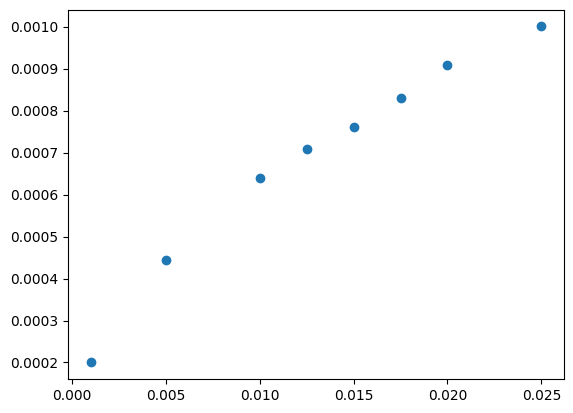

In [240]:
# check for phase transition

delta = 1.5

p = 200
n = int(delta * p)

sigmas2 = [0.001, 0.005, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.025]
tau2 = 1

error_diff = []

prior_info = ("gaussian", (1, None))

for sigma2 in sigmas2 :
    errors = []

    for _ in range(50) :

        beta_norm = generate_beta(p)
        X_bvamp = generate_rri_design(n, p, method = "heavy_tail")
        y_bvamp = generate_response(X_bvamp, beta_norm, sigma2)
        
        estimate_bvamp = vamp_bayes(X_bvamp, y_bvamp, prior_info, oracle_sigma2 = sigma2)

        errors.append(1/p * np.linalg.norm(estimate_bvamp - beta_norm))
        
    error_diff.append(np.median(errors))

plt.scatter(sigmas2, error_diff)
plt.show()

In [124]:
delta = .5

p = 1000
n = int(delta * p)

sigma2 = 0.01
tau2 = 1

beta_norm = generate_beta(p)
X_bvamp = generate_rri_design(n, p, method = "heavy_tail")
y_bvamp = generate_response(X_bvamp, beta_norm, sigma2)

estimate_bvamp = vamp_bayes(X_bvamp, y_bvamp, oracle_params = (sigma2, tau2))
estimate_bamp = amp_bayes(X_bvamp, y_bvamp, oracle_params = (sigma2, tau2), max_iter = 2)

compare_estimates_bvamp = pd.DataFrame(np.array([beta_norm, estimate_bvamp, estimate_bamp]).T, columns = ['true_beta', 'bayes_vamp_estimate', 'bayes_amp_estimate'])
compare_estimates_bvamp.round(4)

,true_beta,bayes_vamp_estimate,bayes_amp_estimate
0,0.7893,0.6072,-9.521060e+07
1,1.0362,0.6380,-2.096918e+08
2,-0.2863,0.5573,-1.534146e+08
3,-0.6332,-0.8464,-9.910917e+07
4,-1.7443,-0.9882,-3.401705e+07
...,...,...,...
995,-1.8919,-1.2562,-1.517822e+08
996,0.8498,-0.6408,6.288639e+07
997,0.2422,0.1109,-3.076814e+08
998,-0.4184,-0.3811,1.250114e+08


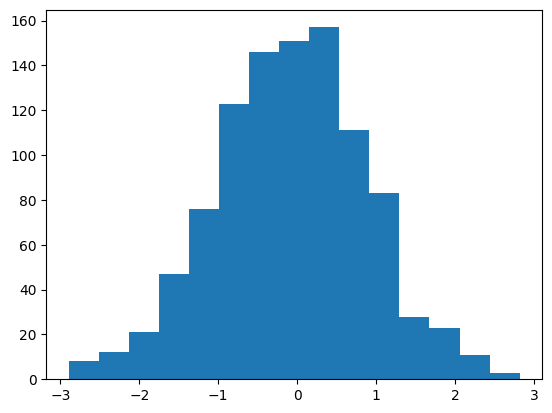

In [116]:
plt.hist(estimate_bvamp, bins = 15)
plt.show()

In [117]:
np.mean(estimate_bvamp), np.var(estimate_bvamp)

(np.float64(-0.07420296965523923), np.float64(0.9097174873397084))

In [118]:
X_bvamp_new = 100 * X_bvamp
y_bvamp_new = 100 * y_bvamp

estimate_bvamp_new = vamp_bayes(X_bvamp_new, y_bvamp_new, oracle_params = (sigma2, tau2))
estimate_bamp = amp_bayes(X_bvamp, y_bvamp, oracle_params = (sigma2, tau2), max_iter = 2)

compare_estimates_bvamp = pd.DataFrame(np.array([beta_norm, estimate_bvamp_new, np.ones(1000)]).T, columns = ['true_beta', 'bayes_vamp_estimate_new', 'bayes_amp_estimate'])
compare_estimates_bvamp.round(4)

,true_beta,bayes_vamp_estimate_new,bayes_amp_estimate
0,-0.0409,-0.0401,1.0
1,-1.4378,-1.4364,1.0
2,-2.8249,-2.8270,1.0
3,1.9462,1.9475,1.0
4,0.2290,0.2301,1.0
...,...,...,...
995,0.3653,0.3631,1.0
996,-1.1300,-1.1345,1.0
997,1.4132,1.4133,1.0
998,-0.7171,-0.7169,1.0


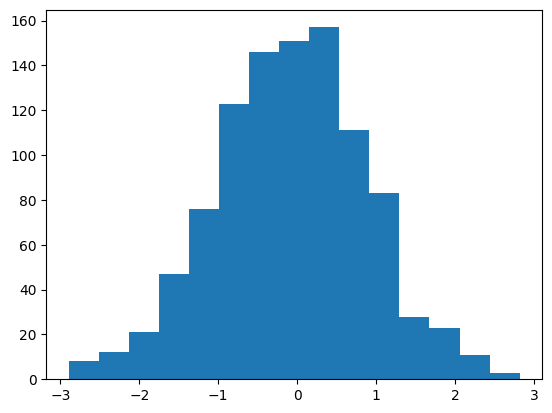

In [119]:
plt.hist(estimate_bvamp_new, bins = 15)
plt.show()

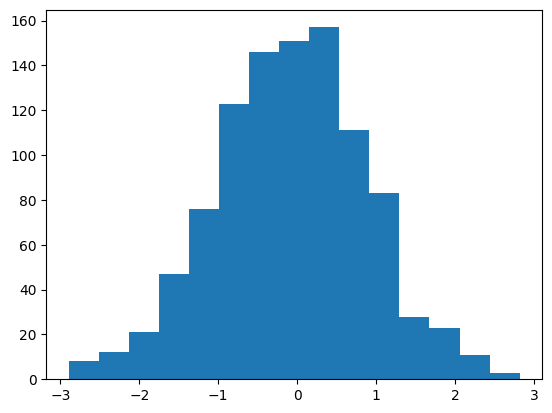

In [120]:
plt.hist(estimate_bvamp, bins = 15)
plt.show()

In [121]:
np.mean(estimate_bvamp_new), np.var(estimate_bvamp_new)

(np.float64(-0.07420327244832504), np.float64(0.9097310020443644))

In [122]:
np.mean(estimate_bvamp), np.var(estimate_bvamp)

(np.float64(-0.07420296965523923), np.float64(0.9097174873397084))

In [666]:
# tagged1
# vamp_bayes(X, y, prior_info : Sequence[prior], oracle_sigma2, max_iter = 100, tol = 1e-8, retrieve = False, verbose = False) :

delta = 1.5

p = 1000
n = int(delta * p)

sigma2 = 0.01
tau2 = 1

theta1 = 0.7
theta2 = 0.4

beta_rade = generate_beta(p, var = tau2) * np.random.binomial(1, theta1, size = p)  # np.random.choice([-1, 0, 1], size = p, p = (theta1, theta2, 1 - theta1 - theta2)) # 2 * np.random.binomial(1, p = 0.5, size = p) - 1 # * generate_beta(p, var = tau2) # np.random.laplace(loc = 0.0, scale = theta, size = p)

X_bvamp = generate_rri_design(n, p, method = "heavy_tail")
y_bvamp = generate_response(X_bvamp, beta_rade, sigma2)

prior = ("bernoulli_normal", (theta1, tau2))

# print(max(r_1_k), gamma_1_k, max(beta_hat_k), b_k, eta_1_k, gamma_2_k, max(r_2_k), c_k)

estimates_bvamp, r_1, r_2 = vamp_bayes(X_bvamp, y_bvamp, prior, sigma2, tol = 1e-4, max_iter = 15, retrieve = True, verbose = True)

compare_estimates_bvamp = pd.DataFrame(np.array([beta_rade, estimates_bvamp[-1], estimate_bamp]).T, columns = ['true_beta', 'bayes_vamp_estimate', 'bayes_amp_estimate'])
compare_estimates_bvamp.round(4)

# np.linalg.norm(beta_rade - estimates_bvamp[-1])
# beta_rade[0] - estimates_bvamp[-1][0]

,true_beta,bayes_vamp_estimate,bayes_amp_estimate
0,-2.9543,-2.9539,-9.521060e+07
1,0.0569,0.0515,-2.096918e+08
2,-0.0000,-0.0031,-1.534146e+08
3,-0.6896,-0.6936,-9.910917e+07
4,-0.6861,-0.6954,-3.401705e+07
...,...,...,...
995,-0.4393,-0.4398,-1.517822e+08
996,-1.3154,-1.3106,6.288639e+07
997,-1.7629,-1.7637,-3.076814e+08
998,-1.5042,-1.4997,1.250114e+08


In [602]:
compare_estimates_bvamp = pd.DataFrame(np.array([beta_rade, estimates_bvamp[1], estimate_bamp]).T, columns = ['true_beta', 'bayes_vamp_estimate', 'bayes_amp_estimate'])
compare_estimates_bvamp.round(4)

,true_beta,bayes_vamp_estimate,bayes_amp_estimate
0,-1.0,-1.0,-9.521060e+07
1,0.0,0.0,-2.096918e+08
2,0.0,0.0,-1.534146e+08
3,0.0,0.0,-9.910917e+07
4,1.0,1.0,-3.401705e+07
...,...,...,...
995,1.0,1.0,-1.517822e+08
996,0.0,0.0,6.288639e+07
997,0.0,0.0,-3.076814e+08
998,1.0,1.0,1.250114e+08


In [480]:
(1/np.cosh(250.68207081733 * 1.0)) ** 2

np.float64(7.284166348767289e-218)

In [356]:
from sklearn.linear_model import Ridge

# NOW, ridge VAMP
# FOUR THINGS TO CHECK
    # matches LASSO solution
    # ASYMPTOTIC NORMALITY
    # check the phase transition for different values of delta
    # better than AMP for various RRI matrices

delta = 5.0

p = 200
n = int(delta * p)

sigma2 = 0.01

beta_0 = generate_beta(p)
X_rvamp = generate_rri_design(n, p, method = "lln")
y_rvamp = generate_response(X_rvamp, beta_0, sigma2)

lambda_rvamp = .01
estimate_rvamp = vamp_ridge(X_rvamp, y_rvamp, reg_lambda = lambda_rvamp, max_iter = 100)

lambda_ridge = lambda_rvamp
ridge = Ridge(alpha = lambda_ridge)
ridge.fit(X_rvamp, y_rvamp)
estimate_ridge = ridge.coef_

compare_estimates_rvamp = pd.DataFrame(np.array([beta_0, estimate_rvamp, estimate_ridge]).T, columns = ['true_beta', 'ridge_vamp_estimate', 'ridge_estimate'])
compare_estimates_rvamp.round(4)

,true_beta,ridge_vamp_estimate,ridge_estimate
0,1.1200,1.1432,1.1431
1,-1.0534,-1.0057,-1.0058
2,0.4071,0.4012,0.4012
3,-1.6896,-1.6240,-1.6238
4,1.9577,1.9126,1.9127
...,...,...,...
195,-1.3689,-1.3252,-1.3251
196,1.9157,1.9363,1.9364
197,-2.9088,-2.9850,-2.9851
198,-1.5206,-1.6064,-1.6064


In [295]:
# NOW, LASSO VAMP
# FOUR THINGS TO CHECK
    # matches LASSO solution
    # ASYMPTOTIC NORMALITY
    # check the phase transition for different values of delta
    # better than AMP for various RRI matrices

delta = 5.0

p = 200
n = int(delta * p)

sigma2 = 0.01

beta_bernnorm = np.random.binomial(1, 0.4, size = p) * generate_beta(p)
X_lvamp = generate_rri_design(n, p, method = "heavy_tail")
y_lvamp = generate_response(X_lvamp, beta_bernnorm, sigma2)

lambda_lamp = 0.14
lambda_lvamp = 0.094
estimate_lvamp = vamp_lasso(X_lvamp, y_lvamp, reg_lambda = lambda_lvamp)
estimate_lamp = amp_lasso(X_lvamp, y_lvamp, reg_lambda = lambda_lamp, max_iter = 5)

lambda_lasso = lambda_lvamp / n
lasso = Lasso(alpha = lasso_lambda)
lasso.fit(X_lvamp, y_lvamp)
estimate_lasso = lasso.coef_

compare_estimates_lvamp = pd.DataFrame(np.array([beta_bernnorm, estimate_lvamp, estimate_lamp, estimate_lasso]).T, columns = ['true_beta', 'lasso_vamp_estimate', 'lasso_amp_estimate', 'lasso_estimate'])
compare_estimates_lvamp.round(4)

,true_beta,lasso_vamp_estimate,lasso_amp_estimate,lasso_estimate
0,0.0000,-0.0044,1.260097e+20,-0.0039
1,-0.0289,-0.0315,-2.214817e+20,-0.0309
2,-0.0000,0.0001,1.861862e+19,0.0000
3,-0.0000,0.0015,-8.172906e+18,0.0012
4,-0.6238,-0.6227,3.367946e+20,-0.6226
...,...,...,...,...
195,1.6186,1.6134,1.103787e+20,1.6135
196,0.0000,0.0035,-4.534073e+20,0.0029
197,-0.1693,-0.1678,-3.379418e+20,-0.1677
198,0.0000,0.0049,-2.366192e+20,0.0042


In [687]:
# vamp_bayes(X, y, prior_info : Sequence[prior], oracle_sigma2, max_iter = 100, tol = 1e-8, retrieve = False, verbose = False) :


deltas = [0.25, 0.5, 0.75, 1.0, 1.25, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

vals = []

for delta in deltas :

    p = 1000
    n = int(delta * p)

    sigma2 = 0.01
    tau2 = 1

    beta_norm = generate_beta(p, var = tau2) # np.random.choice([-1, 0, 1], size = p, p = (theta1, theta2, 1 - theta1 - theta2)) # generate_beta(p, var = tau2) * np.random.binomial(1, theta, size = p) #2 * np.random.binomial(1, theta, size = p) - 1 #* generate_beta(p, var = tau2) # np.random.laplace(loc = 0.0, scale = theta, size = p)

    prior = ("gaussian", (tau2, None))
    X_bvamp = generate_rri_design(n, p, method = "heavy_tail")
    y_bvamp = generate_response(X_bvamp, beta_norm, sigma2)

    estimate_bvamp, r_1, r_2 = vamp_bayes(X_bvamp, y_bvamp, prior, sigma2, verbose = True, retrieve = True)
    
    val = 1/p * np.linalg.norm(X_bvamp @ r_2[-1] - y_bvamp)
    vals.append(val)

compare_estimates_bvamp = pd.DataFrame(np.array([beta_norm, estimate_bvamp[2], estimate_bamp]).T, columns = ['true_beta', 'bayes_vamp_estimate', 'bayes_amp_estimate'])
compare_estimates_bvamp.round(4)

    #np.linalg.norm(beta_rade - estimate_bvamp)

converged at iteration 2
converged at iteration 2
converged at iteration 2
converged at iteration 2
converged at iteration 2
converged at iteration 2
converged at iteration 2
converged at iteration 2
converged at iteration 2
converged at iteration 2
converged at iteration 2
converged at iteration 2


,true_beta,bayes_vamp_estimate,bayes_amp_estimate
0,0.9810,0.9807,-9.521060e+07
1,0.5658,0.5658,-2.096918e+08
2,-0.1130,-0.1133,-1.534146e+08
3,1.8364,1.8360,-9.910917e+07
4,0.0826,0.0825,-3.401705e+07
...,...,...,...
995,-2.9688,-2.9691,-1.517822e+08
996,0.9607,0.9606,6.288639e+07
997,-0.8930,-0.8926,-3.076814e+08
998,-1.6694,-1.6696,1.250114e+08


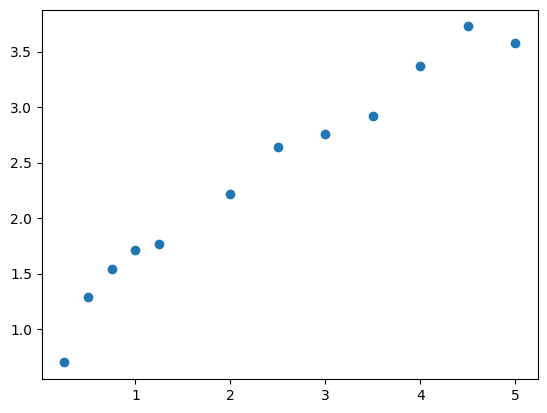

In [414]:
plt.scatter(deltas, vals)